In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-torch/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [5]:
# img_tgt
# nca_tgt
# img_clip
# nca_clip

In [8]:
prompts = [
    "a red apple;a green apple;a blue apple;a red apple",
    "a skinny cat;a normal cat;a fat cat;a very very fat cat",
    "a red apple;a green tree;a cute dog;the yellow sun",
    "random noise;self-replicating molecules;cells floating in primordial soup;alien animals roaming around",
    
    # "a bustling luscious nature landscape",
    # "an artificial life simulation",
    # "self-replication emerging in an artificial life simulation",
    # "a photo of the emergence of open-ended complexity",
]

In [6]:
tgt_imgs = [
    "/home/akarshkumar0101/nca-alife-data/target_imgs/gorilla.png",
    "/home/akarshkumar0101/nca-alife-data/target_imgs/nature.png",
    "/home/akarshkumar0101/nca-alife-data/target_imgs/confetti_ball.png",
    "/home/akarshkumar0101/nca-alife-data/target_imgs/einstein.png",
]

NameError: name 'group' is not defined

In [26]:
cfg_default = dict(seed=0, save_dir=None,
                   img_size=64,
                   n_layers=2, d_state=16, d_embd=32,
                   init_state='point', padding_mode='zeros', dt=0.01, p_drop=0.,
                   rollout_steps=64, bptt_steps=16,
                   prompt=None, n_augs=1, augs="crop+pers",
                   bs=8, lr=5e-4, n_iters=1500000, clip_grad_norm=1.)

n_seeds = 1
cfgs = []

for seed in range(n_seeds):
    for i_prompt, prompt in enumerate(prompts):
        cfg = cfg_default.copy()
        cfg.update(seed=seed, prompt=prompt)
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/prompt={i_prompt}_seed={seed}")
        cfgs.append(cfg)


In [27]:
commands = experiment_utils.create_commands(cfgs, prefix='python nca_multi_prompt_clip.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python nca_multi_prompt_clip.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/prompt=0_seed=0" --img_size=64 --n_layers=2 --d_state=16 --d_embd=32 --init_state="point" --padding_mode="zeros" --dt=0.01 --p_drop=0.0 --rollout_steps=64 --bptt_steps=16 --prompt="a red apple;a green apple;a blue apple;a red apple"                                                     --n_augs=1 --augs="crop+pers" --bs=8 --lr=0.0005 --n_iters=1500000 --clip_grad_norm=1.0
python nca_multi_prompt_clip.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/prompt=1_seed=0" --img_size=64 --n_layers=2 --d_state=16 --d_embd=32 --init_state="point" --padding_mode="zeros" --dt=0.01 --p_drop=0.0 --rollout_steps=64 --bptt_steps=16 --prompt="a skinny cat;a normal cat;a fat cat;a very very fat cat"                                                --n_augs=1 --augs="crop+pers" --bs=8 --lr=0.0005 --n_iters=1500000 --clip_grad_norm=1.0
python nca_multi_prompt_clip.p

# Visualize Results

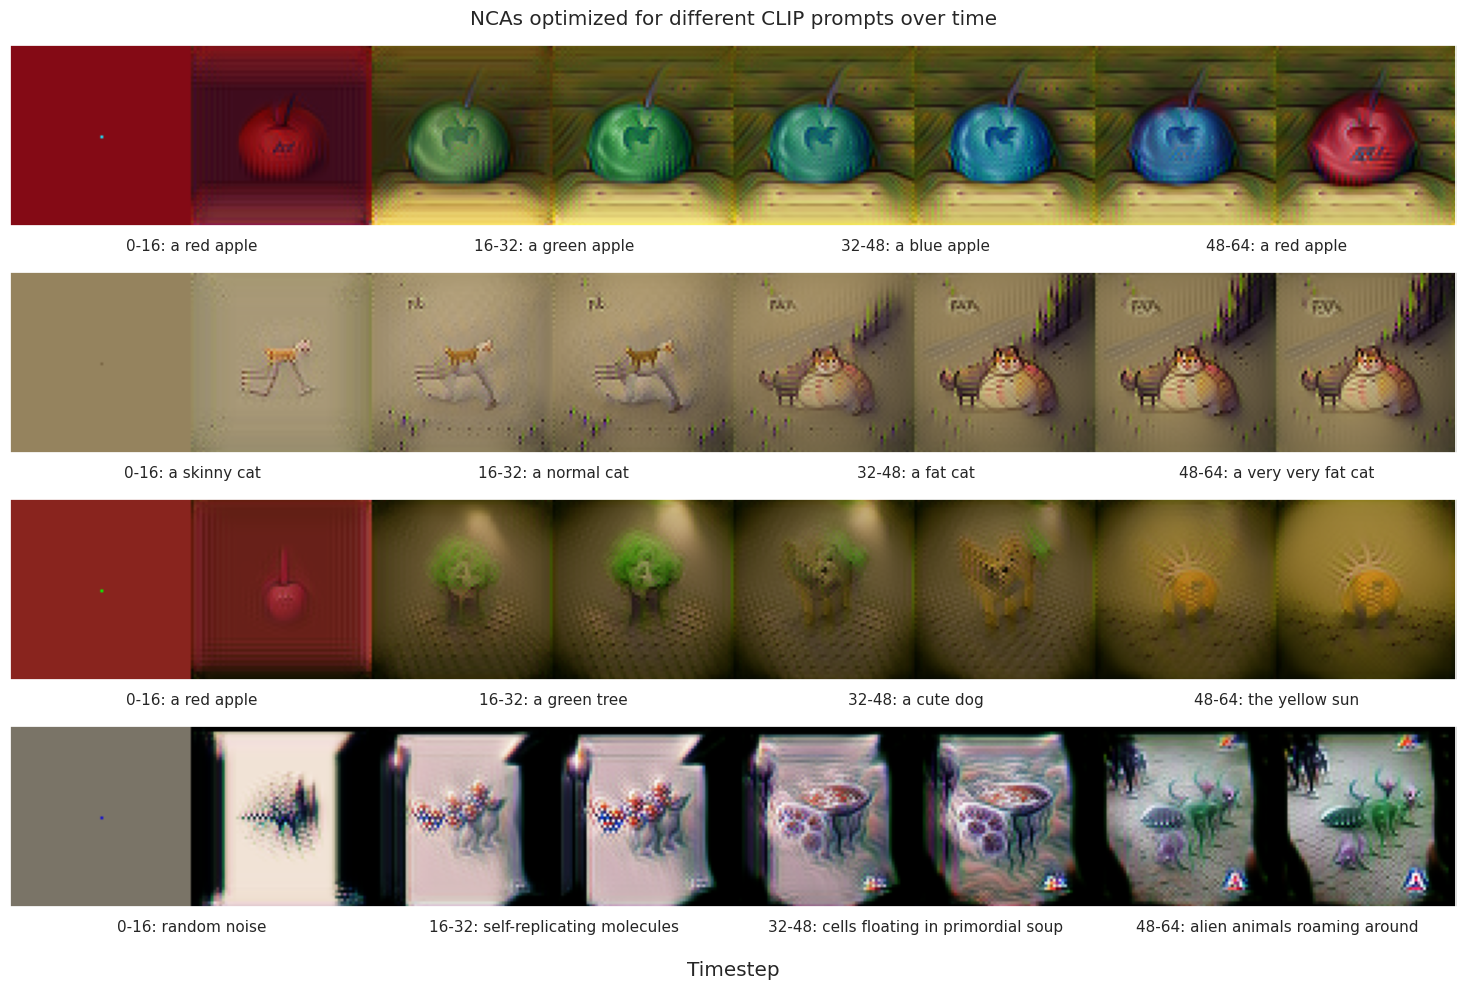

In [166]:
plt.figure(figsize=(20, 10))
seed=0
for i_prompt, prompt in enumerate(prompts):
    save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/prompt={i_prompt}_seed={seed}"
    vid = util.load_pkl(save_dir, 'vid').astype(np.float32)
    plt.subplot(4, 1, i_prompt+1)
    plt.imshow(rearrange(vid[:1, ::8, :, :, :], 'B T H W D -> (B H) (T W) D'))
    plt.grid(False); plt.yticks([])

    a = [f"{i*16}-{i*16+16}: {ai}" for i, ai in enumerate(prompt.split(';'))]
    plt.xticks(np.arange(4)*128+64, a)

plt.gcf().supxlabel('Timestep')
plt.suptitle("NCAs optimized for different CLIP prompts over time")

plt.tight_layout()
plt.show()

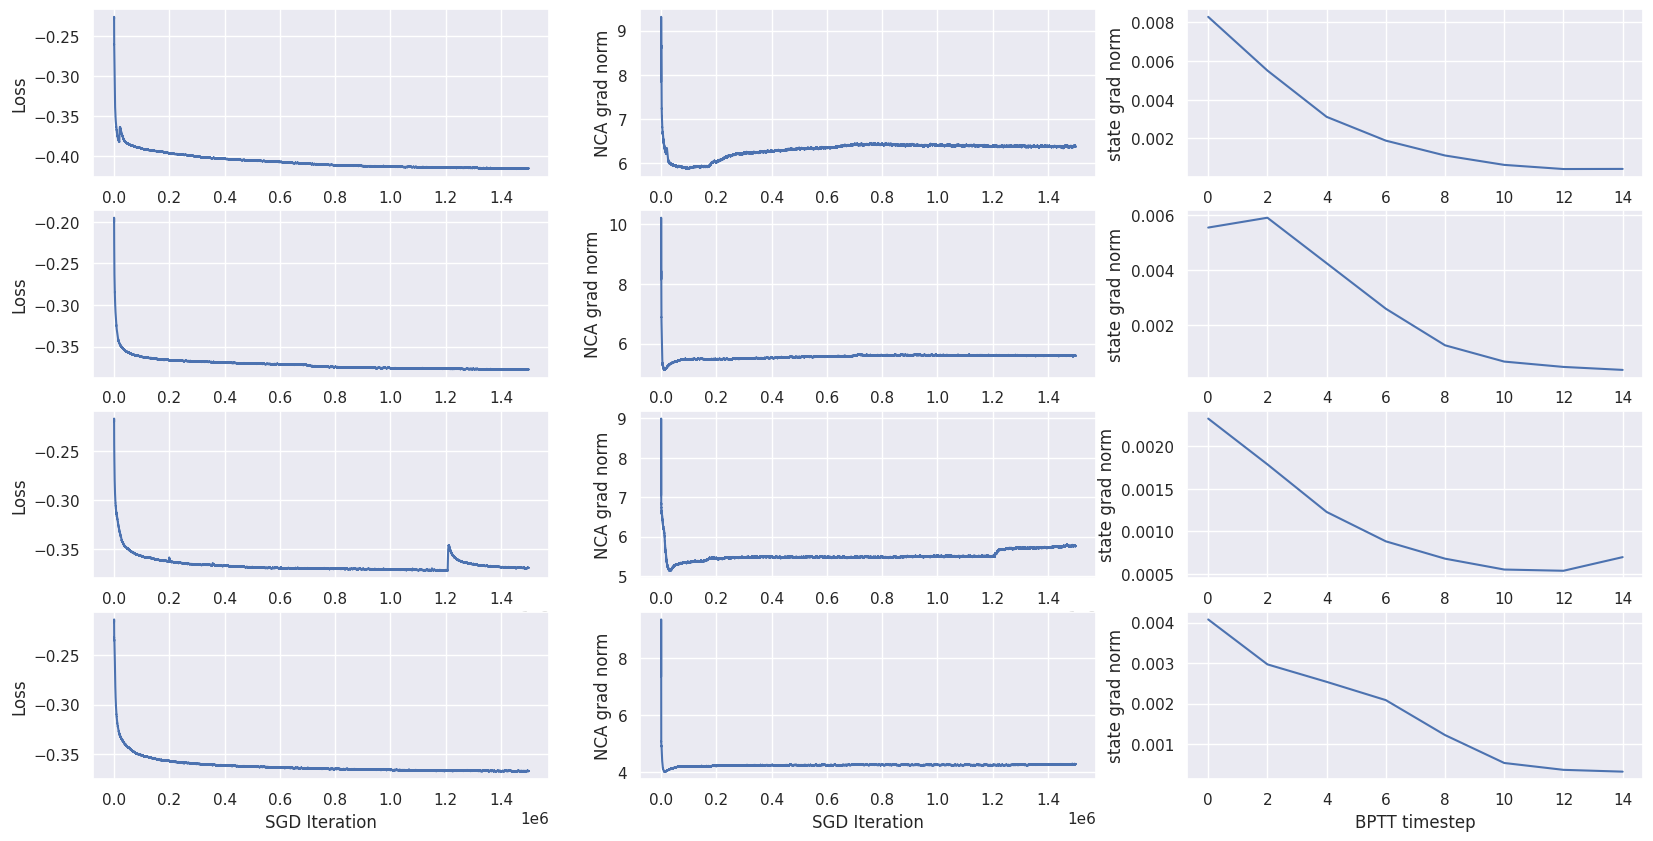

In [184]:
plt.figure(figsize=(20, 10))
seed=0
iplt =0
for i_prompt, prompt in enumerate(prompts):
    save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/prompt={i_prompt}_seed={seed}"
    losses = util.load_pkl(save_dir, 'losses')
    grad_norms = util.load_pkl(save_dir, 'grad_norms')
    df = pd.DataFrame(dict(losses=losses, grad_norms=grad_norms))

    iplt+=1
    plt.subplot(4, 3, iplt)
    df['losses'].ewm(span=5000).mean().plot(ax=plt.gca())
    plt.xlabel("SGD Iteration"); plt.ylabel("Loss")
    
    iplt+=1
    plt.subplot(4, 3, iplt)
    df['grad_norms'].ewm(span=5000).mean().plot(ax=plt.gca())
    plt.xlabel("SGD Iteration"); plt.ylabel("NCA grad norm")
    
    iplt+=1
    plt.subplot(4, 3, iplt)
    grad_vs_times = util.load_pkl(save_dir, 'grad_vs_times')
    plt.plot(np.arange(0, 16, 2), grad_vs_times.mean(axis=0))
    plt.xlabel("BPTT timestep"); plt.ylabel("state grad norm")

plt.show()

In [121]:
from PIL import Image
def save_as_gif(data, file_path):
    """
    Saves a NumPy array (T, H, W, 3) as an animated GIF.
    Args:
    data (np.array): A NumPy array with shape (T, H, W, 3) representing RGB images.
    file_path (str): The file path where the GIF should be saved.
    """
    images = []

    for i in range(data.shape[0]):
        fig, ax = plt.subplots()
        ax.imshow(data[i], interpolation='none')
        ax.axis('off')  # Hide axes

        # Save plot to a PIL Image object
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(Image.fromarray(image))

        plt.close(fig)

    # Save images as a GIF
    images[0].save(file_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)


In [125]:
for seed in range(1):
    for i_prompt in range(4):
        save_dir = f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/prompt={i_prompt}_seed={seed}"
        vid = util.load_pkl(save_dir, 'vid')
        vid = (vid[0]*255).astype(np.uint8)
        save_as_gif(vid, f'{save_dir}/vid.gif')

/tmp/ipykernel_1070422/1271852133.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


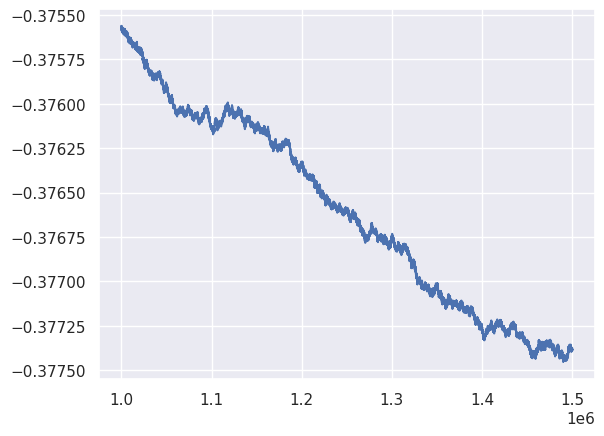

In [103]:
losses = util.load_pkl(save_dir, 'losses')
grad_norms = util.load_pkl(save_dir, 'grad_norms')
df = pd.DataFrame(dict(losses=losses, grad_norms=grad_norms))
# df['losses'].ewm(span=5000).mean().plot(ax=plt.gca())
df['losses'].ewm(span=50000).mean()[-500000:].plot(ax=plt.gca())
# plt.ylim(-.41, -.36)
plt.show()

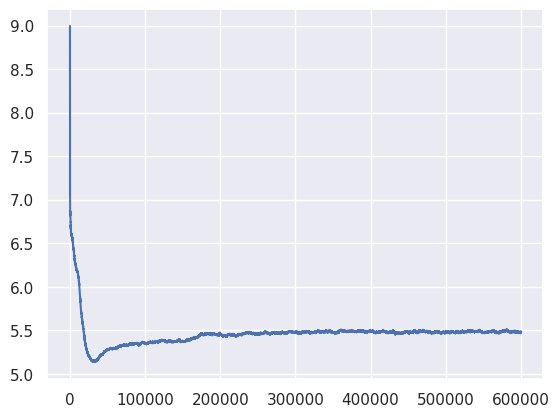

In [81]:
df['grad_norms'].ewm(span=5000).mean().plot(ax=plt.gca())
plt.show()

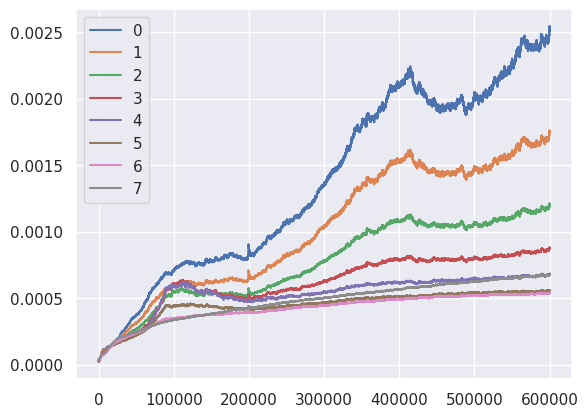

In [89]:
grad_vs_times = util.load_pkl(save_dir, 'grad_vs_times')
df = pd.DataFrame(grad_vs_times)
df.ewm(span=5000).mean().plot(ax=plt.gca())
plt.show()

<Axes: >

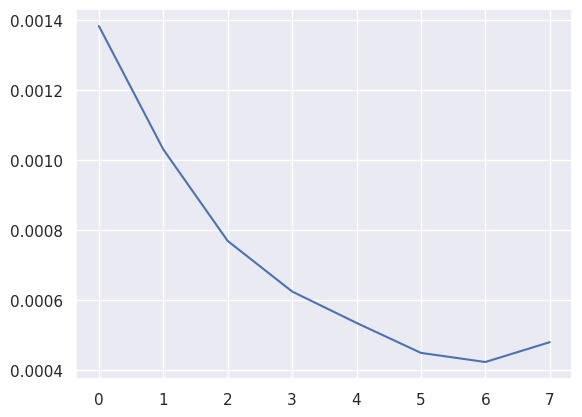

In [91]:
df.mean(axis=0).plot()